# <font color=Black>Capstone Project — The Battle of Neighbourhoods in Patna</font>

## <font color=red>Introduction : </font>

**Patna capital of Bihar state, northern India.Patna is a riverside city that extends along the south bank of the Ganges. Total population of patna is more than 6.5 Million.It has total 41 neighborhood.It seems that over last decade its continuously developing and as a result from 109th position out of 111 cites in 2019 to grabbing 33rd spot in the Ease of living index 2020 released by the Union ministry of housing and urban affairs is a sign of development.The official language of Patna and the one that is most widely spoken is Hindi. However, English is also spoken as a formal language within businesses and government agencies.With it’s diverse culture , comes diverse food items. There are many restaurants,Food Truck and Cafe's in Patna.**





**Our aim is to visualise all major parts of patna so that we can profitize the client and give him best recommendations if he wants to start any business related to below questions.We will provide him location where he can make money.**  

## <font color=Red>Questions that will be answer Later : </font>

- Which area it's better to open Chinese Restaurant?


- Which area it's better to open Cafe?


- Which area it's better to open American Restaurant?


- Which area it's better to open Furniture Store?

In [5]:
#import required libraries
from geopy.geocoders import Nominatim
import geocoder
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import folium
import pandas as pd
import re
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
import numpy as np

## <font color=red>Data</font>

**For this project we need the following data :**

**There are many sites are available to get the open source data.I am using one of the wikipedia page to work on this page 
<a> https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Patna </a>**

## <font color=red>Data Collection</font>

**I am using BeautifulSoup to scrap the data from the mentioned url and take the fields which I will be working on.**

In [4]:

data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Patna").text
soup = BeautifulSoup(data, 'html.parser')

neighborhoodList = []
for row in soup.find_all("div", class_="mw-content-ltr")[0].findAll("li"):
    neighborhoodList.append(row.text)
    
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})

kl_df.head()

,Neighborhood
0,Ashok Rajpath
1,Badalpura
2,"Bailey Road, Patna"
3,Bakhtiarpur
4,Bankipore


In [3]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Patna'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [4]:
# iterate to get the latitude and longitude
coords = [ get_latlng(neighborhood) for neighborhood in kl_df["Neighborhood"].tolist() ]

In [5]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [6]:
kl_df['Latitude'] = df_coords['Latitude']
kl_df['Longitude'] = df_coords['Longitude']

In [46]:
kl_df.head()

,Neighborhood,Latitude,Longitude
0,Ashok Rajpath,25.61726,85.16989
1,Badalpura,25.57955,85.14967
2,"Bailey Road, Patna",25.60437,85.10150
3,Bakhtiarpur,25.46064,85.53914
4,Bankipore,25.61886,85.15568


## <font color=red>Data Visualization</font> 

**After Scrapping the Data Let's Visualize it using Folium.**

In [8]:
address = 'Patna'

geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Patna are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Patna are 25.6093239, 85.1235252.


**Map Of Patna with Neighborhoods denoted in blue circles**

In [9]:
kl_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(kl_map)  
    
kl_map

**Define Foursquare Credentials and Version**

In [11]:
CLIENT_ID = 'PV0JCLGHHK3PRXJUVEWNZS4RBGHAOJO2RXUJOAD5CKQEVLFI' 
CLIENT_SECRET = '1UGQCJ5XHAOWM5WZKJPU1CYJTWE5RKGT4BGMPIJTZ1RE3RWR' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PV0JCLGHHK3PRXJUVEWNZS4RBGHAOJO2RXUJOAD5CKQEVLFI
CLIENT_SECRET:1UGQCJ5XHAOWM5WZKJPU1CYJTWE5RKGT4BGMPIJTZ1RE3RWR


**The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 3000 meters.**

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Lets use the above function  and store the venues data returned in the Kl_venues pandas dataframe.**

In [13]:
kl_venues = getNearbyVenues(names=kl_df['Neighborhood'],
                                   latitudes=kl_df['Latitude'],
                                   longitudes=kl_df['Longitude']
                                  )
kl_venues.head()

Ashok Rajpath
Badalpura
Bailey Road, Patna
Bakhtiarpur
Bankipore
Barh
Beer Chand Patel Path
Bhootnath Road
Bihta
Boring Road
Buddha Colony
Dak Bungalow Crossing, Patna
Danapur
Digha, Patna
Dinapur Cantonment
Exhibition Road, Patna
Fatuha
Frazer Road
Gaighat, Patna
Gandhi Maidan Marg
Gulzarbagh
Indrapuri, Patna
Kankarbagh
Khagaul
Khusrupur
Kidwaipuri
Kumhrar
Masaurhi
Mokama
New Karbigahiya
Nohsa
Paliganj
Pataliputra
Pataliputra Housing Colony
Patna City
Phulwari Sharif
Rajendra Nagar, Patna
Saidpura
Serpentine Road
Maner Sharif
Shivpuri, Patna


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ashok Rajpath,25.61726,85.16989,Gandhi Maidan,25.617395,85.145020,Park
1,Ashok Rajpath,25.61726,85.16989,Domino's Pizza,25.598122,85.162850,Pizza Place
2,Ashok Rajpath,25.61726,85.16989,Cafe Coffee Day,25.617113,85.148861,Café
3,Ashok Rajpath,25.61726,85.16989,Maurya Hotel,25.615456,85.142218,Hotel
4,Ashok Rajpath,25.61726,85.16989,Gargee Grand,25.612909,85.143276,Hotel Bar


In [14]:
kl_venues.shape

(304, 7)

**A total of 304 venues were obtained. Now lets check the number of venues returned per neighborhood.**

In [15]:
kl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ashok Rajpath,8,8,8,8,8,8
Badalpura,5,5,5,5,5,5
"Bailey Road, Patna",11,11,11,11,11,11
Bakhtiarpur,4,4,4,4,4,4
Bankipore,13,13,13,13,13,13
Barh,3,3,3,3,3,3
Beer Chand Patel Path,17,17,17,17,17,17
Bhootnath Road,4,4,4,4,4,4
Bihta,1,1,1,1,1,1


**From the above dataframe we can see that Budha Coloney and Serpentine Road returned the highest number of venues i.e. 21.** 

**First, lets visualize the number of venues obtained in all the neighborhoods of Patna.**

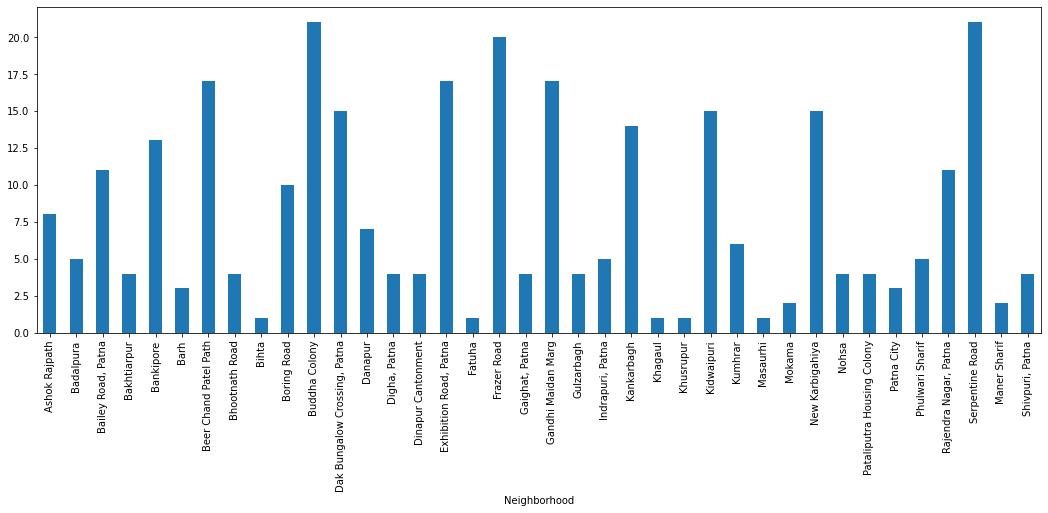

In [16]:

df = kl_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

**Now lets check the unique categories of all the venues returned.**

In [18]:
print('There are {} uniques categories.'.format(len(kl_venues['Venue Category'].unique())))

There are 35 uniques categories.


In [19]:

print('There are {}  categories.'.format(kl_venues['Venue Category'].unique()))

There are ['Park' 'Pizza Place' 'Café' 'Hotel' 'Hotel Bar' 'Fast Food Restaurant'
 'Indian Restaurant' 'Bus Station' 'Train Station' 'Food Court'
 'Golf Course' 'American Restaurant' 'Department Store' 'Track Stadium'
 'Juice Bar' 'ATM' 'Chinese Restaurant' 'River' 'Bar' 'Boat or Ferry'
 'Shopping Mall' 'Multiplex' 'Clothing Store' 'Furniture / Home Store'
 'Cosmetics Shop' 'Snack Place' 'Cricket Ground' "Women's Store"
 'Movie Theater' 'Platform' 'Garden' 'Restaurant' 'Accessories Store'
 'Gym / Fitness Center' 'Sculpture Garden']  categories.


## <font color=red> One hot Encoding</font> 

**One hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood.**

In [20]:
kl_onehot = pd.get_dummies(kl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['Neighborhood'] = kl_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

kl_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Clothing Store,...,Pizza Place,Platform,Restaurant,River,Sculpture Garden,Shopping Mall,Snack Place,Track Stadium,Train Station,Women's Store
0,Ashok Rajpath,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ashok Rajpath,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Ashok Rajpath,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ashok Rajpath,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Rajpath,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.**

In [22]:
kl_grouped = kl_onehot.groupby('Neighborhood').mean().reset_index()
kl_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Clothing Store,...,Pizza Place,Platform,Restaurant,River,Sculpture Garden,Shopping Mall,Snack Place,Track Stadium,Train Station,Women's Store
0,Ashok Rajpath,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.000000,0.0,...,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Badalpura,0.0,0.0,0.000000,0.0,0.0,0.2,0.200000,0.000000,0.0,...,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.200000,0.0
2,"Bailey Road, Patna",0.0,0.0,0.090909,0.0,0.0,0.0,0.181818,0.000000,0.0,...,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.0
3,Bakhtiarpur,0.5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.0
4,Bankipore,0.0,0.0,0.000000,0.0,0.0,0.0,0.076923,0.076923,0.0,...,0.153846,0.0,0.0,0.076923,0.0,0.0,0.0,0.000000,0.076923,0.0


In [23]:
num_top_venues = 5

for hood in kl_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kl_grouped[kl_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ashok Rajpath----
               venue  freq
0        Pizza Place  0.25
1              Hotel  0.12
2  Indian Restaurant  0.12
3               Café  0.12
4               Park  0.12


----Badalpura----
           venue  freq
0  Train Station   0.2
1    Bus Station   0.2
2           Café   0.2
3     Food Court   0.2
4    Pizza Place   0.2


----Bailey Road, Patna----
                 venue  freq
0                 Café  0.18
1  American Restaurant  0.09
2                Hotel  0.09
3        Track Stadium  0.09
4          Golf Course  0.09


----Bakhtiarpur----
               venue  freq
0                ATM   0.5
1      Train Station   0.5
2           Platform   0.0
3  Indian Restaurant   0.0
4          Juice Bar   0.0


----Bankipore----
           venue  freq
0    Pizza Place  0.15
1          Hotel  0.15
2      Hotel Bar  0.08
3  Train Station  0.08
4      Juice Bar  0.08


----Barh----
               venue  freq
0                ATM  0.33
1      Train Station  0.33
2                

**The following function returns the top_venues of each neighborhood.**

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Lets use the above function to obtain the 10 most common venues in each neighborhood and store in the new pandas dataframe neighborhoods_venues_sorted.**

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kl_grouped['Neighborhood']

for ind in np.arange(kl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ashok Rajpath,Pizza Place,Park,Fast Food Restaurant,Hotel,Hotel Bar,Indian Restaurant,Café,Clothing Store,Department Store,Cricket Ground
1,Badalpura,Pizza Place,Bus Station,Food Court,Café,Train Station,Boat or Ferry,Bar,American Restaurant,Chinese Restaurant,Garden
2,"Bailey Road, Patna",Café,Park,Golf Course,Department Store,Hotel,Juice Bar,Pizza Place,Fast Food Restaurant,American Restaurant,Track Stadium
3,Bakhtiarpur,ATM,Train Station,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Golf Course
4,Bankipore,Hotel,Pizza Place,Park,Juice Bar,Train Station,River,Hotel Bar,Café,Fast Food Restaurant,Chinese Restaurant


## <font color=red>Data Analytics</font>

**There are many techniques are available in Data science field. For my project, I am going to use clustering. Particularly, I am going to use K-Means clustering. So, I need to know how many optimal number of cluster could be better for my data.To find the optimal number of clusters we will use silhouette score metric technique.**

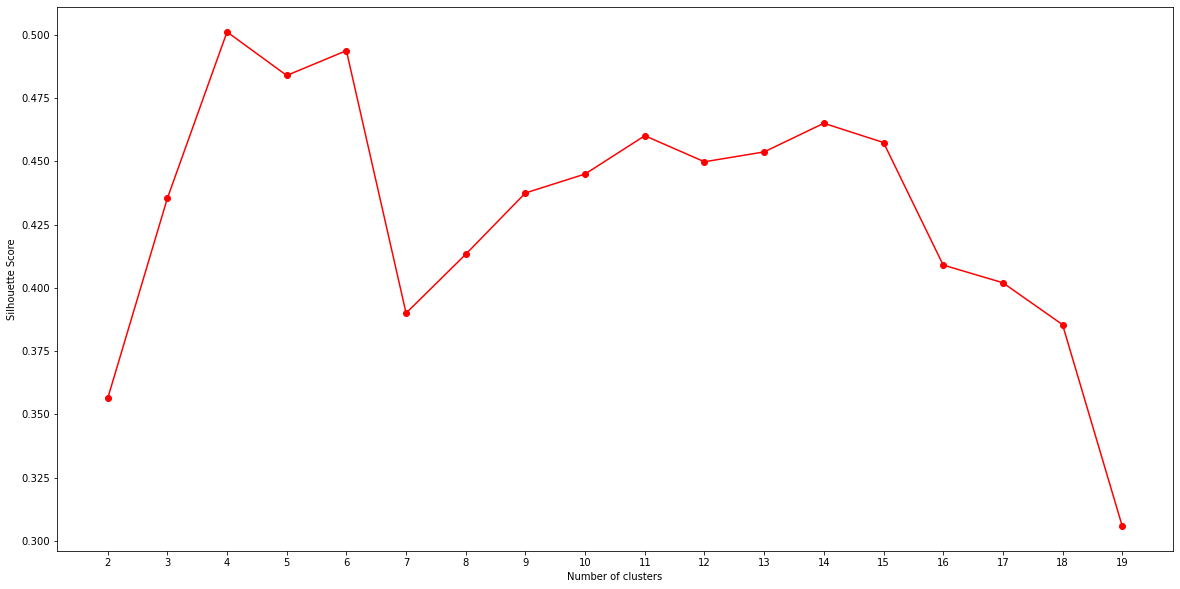

In [26]:
kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

max_score = 20
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kl_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(kl_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

## <font color=red> Model evaluation </font>

**Now we have cleaned data and found all the pre-requisite to model our data From the graph it looks cluster 4 could be the better one.so, let's use number of clusters as 4.**

In [27]:
kclusters = 4

kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 0, 1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 0, 1, 3, 1, 0, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1])

**Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe kl_merged which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.**

In [28]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_merged = kl_df

# merge chn_grouped with chn_data to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kl_merged.head() # check the last columns

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ashok Rajpath,25.61726,85.16989,1.0,Pizza Place,Park,Fast Food Restaurant,Hotel,Hotel Bar,Indian Restaurant,Café,Clothing Store,Department Store,Cricket Ground
1,Badalpura,25.57955,85.14967,1.0,Pizza Place,Bus Station,Food Court,Café,Train Station,Boat or Ferry,Bar,American Restaurant,Chinese Restaurant,Garden
2,"Bailey Road, Patna",25.60437,85.10150,1.0,Café,Park,Golf Course,Department Store,Hotel,Juice Bar,Pizza Place,Fast Food Restaurant,American Restaurant,Track Stadium
3,Bakhtiarpur,25.46064,85.53914,0.0,ATM,Train Station,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Golf Course
4,Bankipore,25.61886,85.15568,1.0,Hotel,Pizza Place,Park,Juice Bar,Train Station,River,Hotel Bar,Café,Fast Food Restaurant,Chinese Restaurant


In [29]:

kl_merged.dropna(inplace=True)
kl_merged.astype({'Cluster Labels': 'int32'}).dtypes

Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [30]:
df = kl_merged.copy([['Cluster Labels', 'Neighborhood']])
a = df.groupby(['Cluster Labels'])['Neighborhood'].value_counts()
print(a)

Cluster Labels  Neighborhood                
0.0             Bakhtiarpur                     1
                Barh                            1
                Bhootnath Road                  1
                Danapur                         1
                Dinapur Cantonment              1
                Gaighat, Patna                  1
                Khagaul                         1
                Maner Sharif                    1
                Mokama                          1
                Nohsa                           1
                Pataliputra Housing Colony      1
                Patna City                      1
                Phulwari Sharif                 1
1.0             Ashok Rajpath                   1
                Badalpura                       1
                Bailey Road, Patna              1
                Bankipore                       1
                Beer Chand Patel Path           1
                Boring Road                     1
     

In [31]:
#Visualize the cluster
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

## <font color=red>Cluster 1 </font>

In [32]:
kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bakhtiarpur,ATM,Train Station,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Golf Course
5,Barh,ATM,Bar,Train Station,American Restaurant,Accessories Store,Boat or Ferry,Bus Station,Café,Chinese Restaurant,Golf Course
7,Bhootnath Road,ATM,Boat or Ferry,Pizza Place,Train Station,American Restaurant,Bar,Accessories Store,Bus Station,Café,Chinese Restaurant
12,Danapur,ATM,Cosmetics Shop,Furniture / Home Store,Train Station,Snack Place,American Restaurant,Bar,Boat or Ferry,Bus Station,Café
14,Dinapur Cantonment,ATM,Snack Place,Train Station,Accessories Store,American Restaurant,Bar,Boat or Ferry,Bus Station,Café,Garden
18,"Gaighat, Patna",ATM,Park,Golf Course,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Clothing Store
23,Khagaul,ATM,Clothing Store,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Chinese Restaurant,Golf Course
28,Mokama,ATM,Clothing Store,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Chinese Restaurant,Golf Course
30,Nohsa,ATM,Restaurant,Clothing Store,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Chinese Restaurant
33,Pataliputra Housing Colony,ATM,Boat or Ferry,Pizza Place,Train Station,American Restaurant,Bar,Accessories Store,Bus Station,Café,Chinese Restaurant


In [33]:
cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

ATM                    13
Chinese Restaurant     10
Bus Station             8
Boat or Ferry           8
Café                    8
Bar                     8
American Restaurant     8
Golf Course             7
Train Station           7
Accessories Store       7
dtype: int64


## <font color=red>Cluster 2 </font> 

In [34]:
kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ashok Rajpath,Pizza Place,Park,Fast Food Restaurant,Hotel,Hotel Bar,Indian Restaurant,Café,Clothing Store,Department Store,Cricket Ground
1,Badalpura,Pizza Place,Bus Station,Food Court,Café,Train Station,Boat or Ferry,Bar,American Restaurant,Chinese Restaurant,Garden
2,"Bailey Road, Patna",Café,Park,Golf Course,Department Store,Hotel,Juice Bar,Pizza Place,Fast Food Restaurant,American Restaurant,Track Stadium
4,Bankipore,Hotel,Pizza Place,Park,Juice Bar,Train Station,River,Hotel Bar,Café,Fast Food Restaurant,Chinese Restaurant
6,Beer Chand Patel Path,Park,Fast Food Restaurant,Hotel,Café,Golf Course,Train Station,Hotel Bar,Indian Restaurant,Juice Bar,Department Store
9,Boring Road,Fast Food Restaurant,Juice Bar,Track Stadium,Golf Course,Shopping Mall,American Restaurant,Department Store,Café,Indian Restaurant,Multiplex
10,Buddha Colony,Hotel,Fast Food Restaurant,Indian Restaurant,Café,Department Store,Clothing Store,Chinese Restaurant,Train Station,Hotel Bar,Juice Bar
11,"Dak Bungalow Crossing, Patna",Fast Food Restaurant,Hotel,Café,Pizza Place,Department Store,Train Station,Hotel Bar,Indian Restaurant,Juice Bar,Park
13,"Digha, Patna",Multiplex,Shopping Mall,Indian Restaurant,Café,Women's Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop
15,"Exhibition Road, Patna",Pizza Place,Hotel,Fast Food Restaurant,Park,Train Station,Hotel Bar,Indian Restaurant,Juice Bar,Chinese Restaurant,Department Store


In [35]:
cluster2 = kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Fast Food Restaurant    19
Café                    17
Hotel                   17
Indian Restaurant       16
Park                    15
Department Store        14
Pizza Place             14
Train Station           14
Hotel Bar               12
Juice Bar               12
dtype: int64


## <font color=red>Cluster 3 </font>

In [36]:
kl_merged.loc[kl_merged['Cluster Labels'] == 2, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Khusrupur,Platform,Women's Store,Clothing Store,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Chinese Restaurant
27,Masaurhi,Platform,Women's Store,Clothing Store,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Chinese Restaurant


In [37]:
cluster3 = kl_merged.loc[kl_merged['Cluster Labels'] == 2, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Fast Food Restaurant      2
Food Court                2
Furniture / Home Store    2
Platform                  2
Women's Store             2
Cosmetics Shop            2
Chinese Restaurant        2
Cricket Ground            2
Department Store          2
Clothing Store            2
dtype: int64


## <font color=red>Cluster 4 </font>

In [38]:
kl_merged.loc[kl_merged['Cluster Labels'] == 3, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bihta,Train Station,Golf Course,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Women's Store
16,Fatuha,Train Station,Golf Course,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Department Store,Cricket Ground,Cosmetics Shop,Women's Store


In [39]:
cluster4 = kl_merged.loc[kl_merged['Cluster Labels'] == 3, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Fast Food Restaurant      2
Food Court                2
Furniture / Home Store    2
Department Store          2
Women's Store             2
Cosmetics Shop            2
Cricket Ground            2
Golf Course               2
Train Station             2
Garden                    2
dtype: int64


## <font color=red>Analysis </font>

**Lets visulaize the top 5 most common venue categories in each of the cluster.**

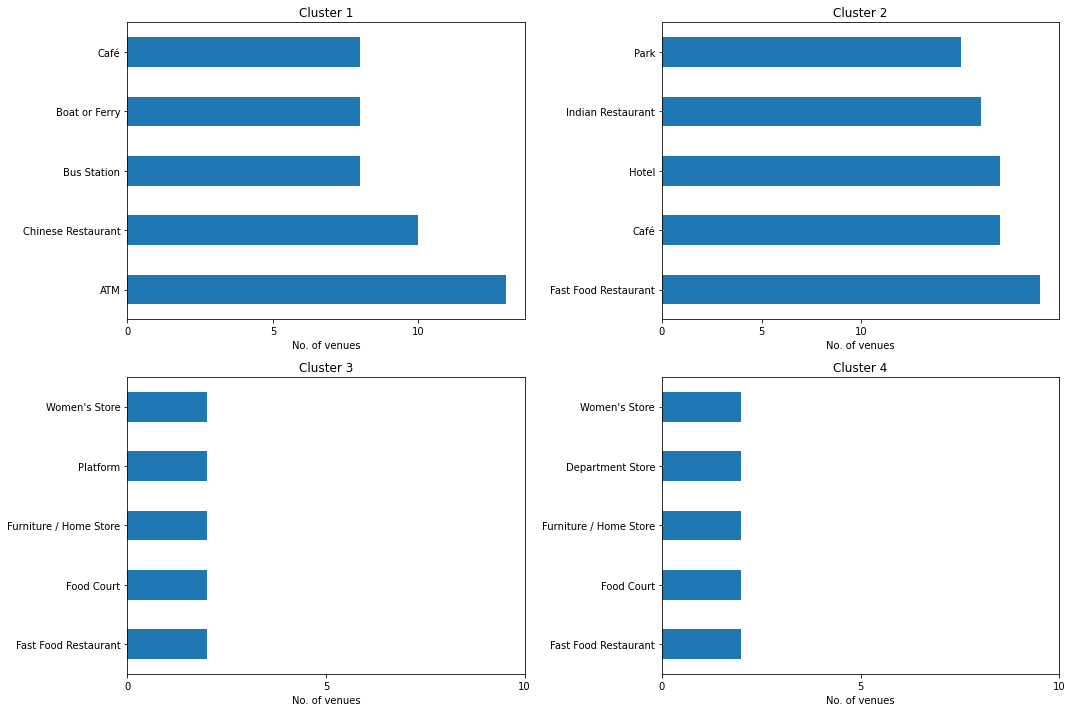

In [42]:

df_list = [venues1 ,venues2, venues3, venues4]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

## <font color=red>This plot can be used to suggest valuable information regarding our Questions.</font>

In [43]:
kl_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(kl_clusters_map)
       
kl_clusters_map

## <font color=red>Answer 1</font> 

**Kankarbagh , Boring Road, Frazer Road , Rajender nagar are the best neighborhoods for Chinese Restaurant as in Cluster 2 and Cluster 4 has no such Restaurant so if anyone wants to open Chinese Restaurant then the business be in profit.**

## <font color=red>Answer 2</font> 

**Bhita , Masaurhi have no Cafe to chill out so the people who live there would covered big distance if they want to go to Cafe.As those area are still not well developed so if new concept like cafe will start then there is a high probability to make good money**

## <font color=red>Answer 3</font>

**People of patna also like American style food and also there is not so many american restaurant so if anyone wants to open American Restaurant then it willl be a game changer for him. Places like Exhibition Road , New Karbhigya ,Gandhi maidan marg   are well developed and good for business** 

## <font color=red>Answer 4</font>

**After Food the most growing buisness in Patna is Furniture Store. Places like Digha , Buddha Colony , Danapur are good to start.** 

# <font color=red>Conclusion </font> 

**Purpose of this project was to analyze the neighborhoods of Patna and create a clustering model to suggest places to start a new business based on the category. The neighborhoods data was obtained from wikipedia and the Foursquare API was used to find the major venues in each neighborhood.Then locations were used to create a clustering model. The best number of clusters i.e. 4 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.**

**A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business.**

**A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.**

# <font color=red> Thank you </font>

**This Notebook Was Created by Shrey Bhardwaj**